In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.stats import mannwhitneyu
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from lgde import Thresholding, LGDE, evaluate_prediction

In [2]:
plt.rcParams.update({'font.size': 18})

# Experiment on hate speech-related benchmark data

## 1) Data input and pre-processing

In [3]:
# load fine-tuned embeddings for different dimensions
embedding_50d = pd.read_pickle("data/glove_redgab_15_0.8_50d_1.0mu_df.pkl")
embedding_100d = pd.read_pickle("data/glove_redgab_15_0.8_100d_1.0mu_df.pkl")
embedding_300d = pd.read_pickle("data/glove_redgab_15_0.8_300d_1.0mu_df.pkl")

# load hyper-parameter tuning results
results_50d = pd.read_pickle("data/gs_th_lgde_glove_redgab_15_0.8_50d_1.0mu_df.pkl")
results_100d = pd.read_pickle("data/gs_th_lgde_glove_redgab_15_0.8_100d_1.0mu_df.pkl")
results_300d = pd.read_pickle("data/gs_th_lgde_glove_redgab_15_0.8_300d_1.0mu_df.pkl")

In [4]:
# retrieve word vectors at different dimensions
word_vecs_50d = np.zeros((embedding_50d["word_vector"].shape[0], embedding_50d["word_vector"][0].shape[0]))
for i in range(word_vecs_50d.shape[0]):
    word_vecs_50d[i, :] = embedding_50d["word_vector"][i]

word_vecs_100d = np.zeros((embedding_100d["word_vector"].shape[0], embedding_100d["word_vector"][0].shape[0]))
for i in range(word_vecs_100d.shape[0]):
    word_vecs_100d[i, :] = embedding_100d["word_vector"][i]

word_vecs_300d = np.zeros((embedding_300d["word_vector"].shape[0], embedding_300d["word_vector"][0].shape[0]))
for i in range(word_vecs_300d.shape[0]):
    word_vecs_300d[i, :] = embedding_300d["word_vector"][i]

In [5]:
# get word list
word_list = list(embedding_50d["word_string"])

# get document frequency
doc_freq = list(embedding_50d["doc_frequency"])

In [6]:
# load redgab data and split into train and test
with open("data/redgab_pos_data.pkl", "rb") as handle:
    domain_data = pickle.load(handle)
    
X_train, X_test, y_train, y_test = train_test_split(
    domain_data.data,
    domain_data.target,
    test_size=0.25,
    stratify=domain_data.target,
    random_state=42,
)

In [7]:
# compute document-term matrix for train
vectorizer = CountVectorizer(vocabulary=word_list)
word_counts_train = vectorizer.fit_transform(X_train)
dt_train = pd.DataFrame(word_counts_train.toarray(), columns=word_list)

# and for test
word_counts_test = vectorizer.fit_transform(X_test)
dt_test = pd.DataFrame(word_counts_test.toarray(), columns=word_list)

### 1.1) Compute likelihood ratios for words

In [8]:
# get all positive documents
X_pos = np.asarray(domain_data.data)[domain_data.target>0]

# get all negative documents
X_neg = np.asarray(domain_data.data)[domain_data.target==0]

# compute binary document-term matrix for positive documents
binary_vectorizer = CountVectorizer(vocabulary=word_list, binary=True)
word_counts_pos = binary_vectorizer.fit_transform(X_pos)
dt_pos = pd.DataFrame(word_counts_pos.toarray(), columns=word_list)

# and for negative documents
word_counts_neg = binary_vectorizer.fit_transform(X_neg)
dt_neg = pd.DataFrame(word_counts_neg.toarray(), columns=word_list)

# compute probability
prob_pos = dt_pos.sum() / len(X_pos)
prob_neg = dt_neg.sum() / len(X_neg)

# define positive likelihood ratio
likelihood_ratio_positive = prob_pos / prob_neg

del dt_pos, dt_neg

## 2) Properties of seed dictionary

In [9]:
# seed dictionary is defined as top 5 most frequent hate keywords according to Qian et al.
seed_dict = ["nigger", "faggot", "retard", "retarded", "cunt"]

In [10]:
# evaluate effective seed dictionary on train
print("Train scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict, y_train, dt_train)

# evaluate effective seed dictionary on test
print("\nTest scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict, y_test, dt_test)

Train scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.859     0.971     0.912     27169
        True      0.931     0.710     0.806     14905

    accuracy                          0.879     42074
   macro avg      0.895     0.841     0.859     42074
weighted avg      0.885     0.879     0.874     42074


Test scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.857     0.972     0.911      9057
        True      0.932     0.703     0.802      4968

    accuracy                          0.877     14025
   macro avg      0.894     0.838     0.856     14025
weighted avg      0.883     0.877     0.872     14025



In [11]:
# compute likelihood ratios for seed keywords
likelihood_ratio_positive[seed_dict]

nigger      82.188888
faggot      78.966956
retard      18.069710
retarded    15.096898
cunt        15.922463
dtype: float64

## 3) Comparison of thresholding and LGDE across dictionary sizes

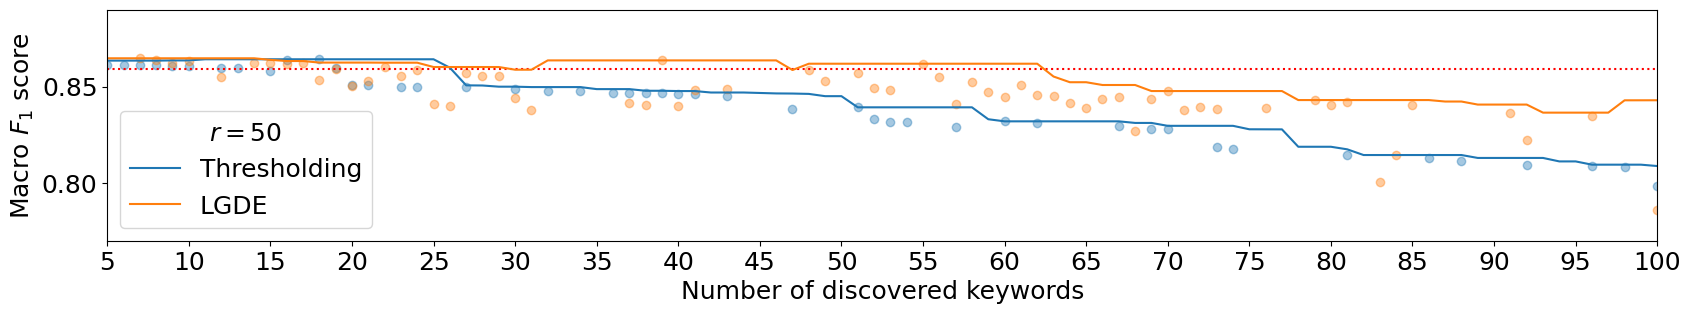

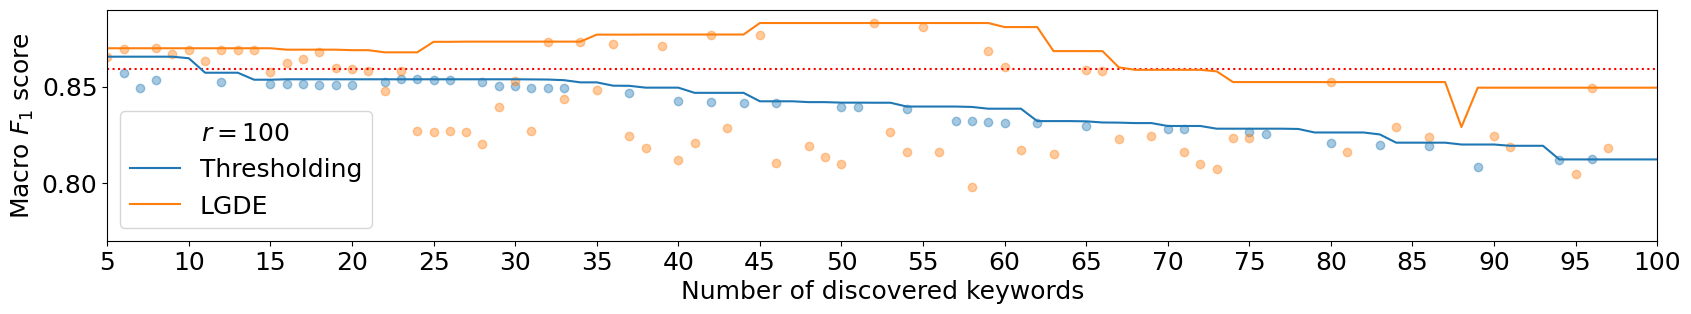

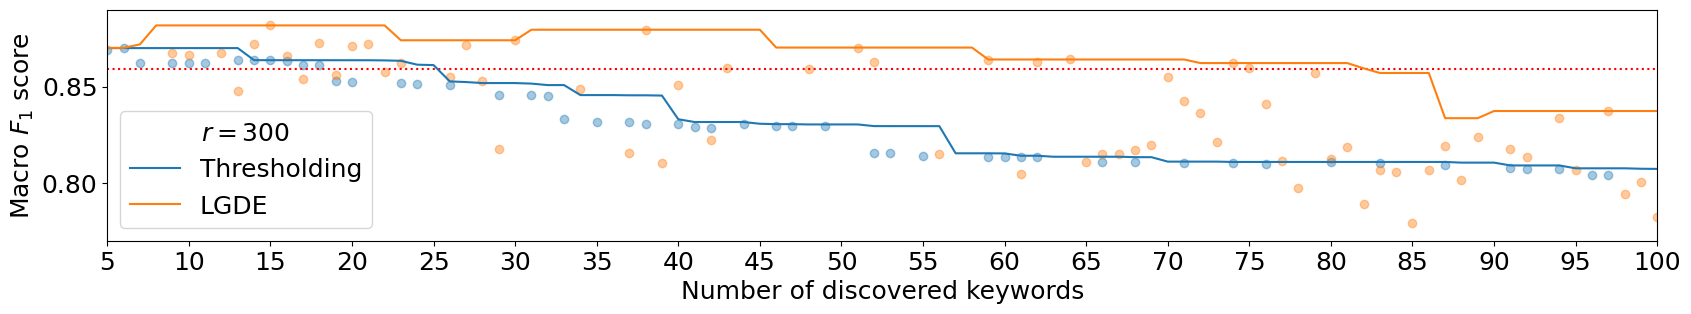

In [12]:
dimension_string = ["50","100","300"]

for j, results in enumerate([results_50d,results_100d,results_300d]):

    # unpack results for thresholding
    eps = results["th"]["eps"]
    fscore_th = results["th"]["fscore"]
    precision_th = results["th"]["precision"]
    recall_th = results["th"]["recall"]
    size_th = results["th"]["size"]

    # unpack results for LGDE
    times = results["lgde"]["times"]
    ks = results["lgde"]["ks"]
    commmunities = results["lgde"]["communities"]
    fscore_lgde = results["lgde"]["fscore"]
    precision_lgde = results["lgde"]["precision"]
    recall_lgde = results["lgde"]["recall"]
    size_lgde = results["lgde"]["size"]

    ###################
    # comparison plot #
    ###################

    # keep only best F1 score per size for LGDE
    df_lgde_results = pd.DataFrame({"s":size_lgde.flatten(),"f1":fscore_lgde.flatten()})
    df_lgde_results = df_lgde_results.groupby(by="s").max()

    s_lgde = np.asarray(list(df_lgde_results.to_dict()["f1"].keys()),dtype=int)
    f_lgde = np.asarray(list(df_lgde_results.to_dict()["f1"].values()))

    # keep only best F1 score per size for thresholding
    df_th_results = pd.DataFrame({"s":size_th.flatten(),"f1":fscore_th.flatten()})
    df_th_results = df_th_results.groupby(by="s").max()

    s_th = np.asarray(list(df_th_results.to_dict()["f1"].keys()),dtype=int)
    f_th = np.asarray(list(df_th_results.to_dict()["f1"].values()))

    # apply max pooling to LGDE
    block_size = 15
    f_lgde_max = []
    sizes = np.arange(1,int(s_lgde.max())+1)
    for i in range(len(sizes)):
        try:
            f_lgde_max.append(f_lgde[(sizes[i]-int(block_size/2)<=s_lgde) * (s_lgde<=sizes[i]+int(block_size/2))].max())
        except:
            f_lgde_max.append(np.nan)
    f_lgde_max = np.asarray(f_lgde_max)

    # apply max pooling to thresholding
    f_th_max = []
    for i in range(len(sizes)):
        f_th_max.append(f_th[(sizes[i]-int(block_size/2)<=s_th) * (s_th<=sizes[i]+int(block_size/2))].max())
    f_th_max = np.asarray(f_th_max)

    # plot
    fig, ax = plt.subplots(1, figsize=(20, 3))
    ax.scatter(s_th[s_th<=s_lgde.max()],f_th[s_th<=s_lgde.max()],alpha=0.4)
    ax.scatter(s_lgde,f_lgde, alpha=0.4)

    ax.axhline(y=0.859, c="red",ls=":")

    ax.plot(sizes, f_th_max, c="C0",label="Thresholding")
    ax.plot(sizes,f_lgde_max, c="C1",label="LGDE")

    ax.legend(loc=3,title=f"$r=${dimension_string[j]}")
    ax.set(ylim=(0.77,0.89),xlim=(5,100),xticks=np.arange(5,101,5))
    ax.set(xlabel="Number of discovered keywords", ylabel="Macro $F_1$ score")
    plt.savefig("figures/" +dimension_string[j]+'comparison.pdf', bbox_inches='tight')

    plt.show()

## 4) Comparison between optimal dictionaries for dimension $r=50$

In [13]:
# size constraints
min_size = 30
max_size = 50

In [14]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_50d["th"]["eps"]
fscore_th = results_50d["th"]["fscore"]
precision_th = results_50d["th"]["precision"]
recall_th = results_50d["th"]["recall"]
size_th = results_50d["th"]["size"]

# unpack results for LGDE
times = results_50d["lgde"]["times"]
ks = results_50d["lgde"]["ks"]
commmunities = results_50d["lgde"]["communities"]
fscore_lgde = results_50d["lgde"]["fscore"]
precision_lgde = results_50d["lgde"]["precision"]
recall_lgde = results_50d["lgde"]["recall"]
size_lgde = results_50d["lgde"]["size"]

# apply size constraints
fscore_sc_lgde = fscore_lgde.copy()
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.NaN
fscore_sc_th[size_th > max_size] = np.NaN
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.NaN
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.NaN

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_50d = eps[ind_th]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_50d = ks[ind_lgde[0]]
best_t_50d = times[ind_lgde[1]]


### Thresholding ###

Best epsilon at $r=50$: 0.774


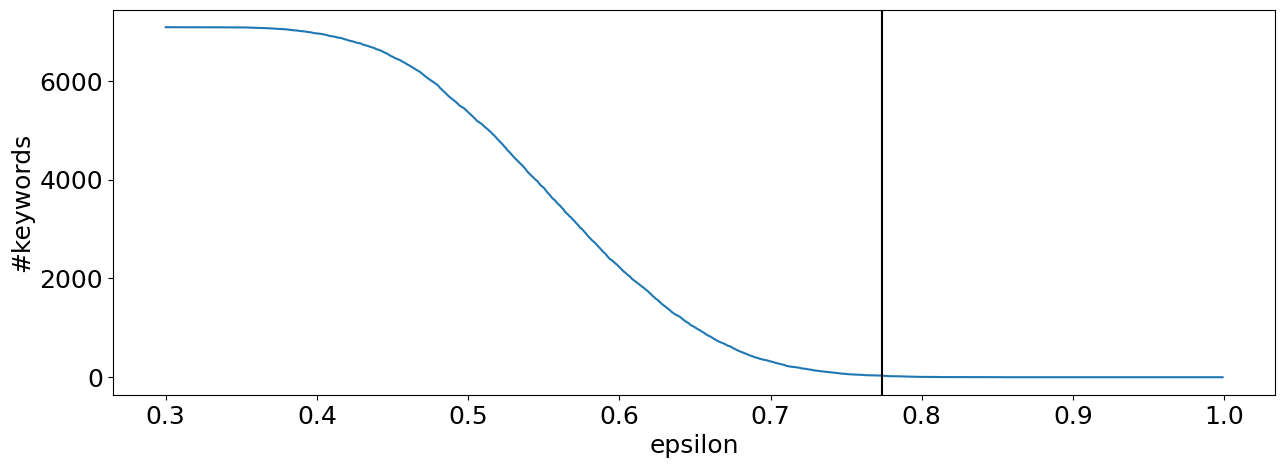

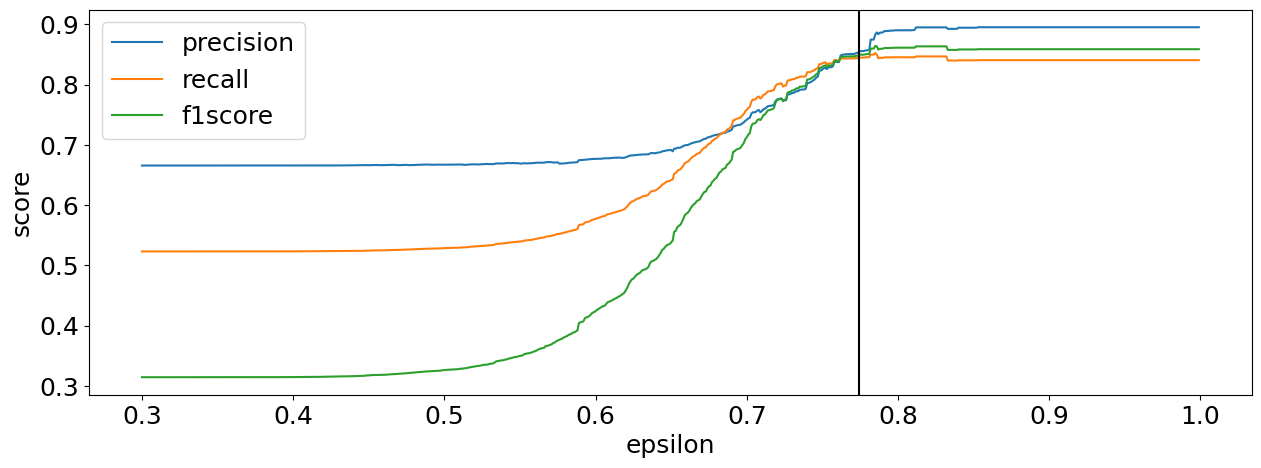

Number of discovered keywords at $r=50$: 30 

Epsilon balls:

nigger --> ['nigger', 'fuck', 'niggers', 'faggot', 'asshole', 'bitch', 'slur', 'weasel', 'nigga', 'spouting']
faggot --> ['paki', 'nigger', 'niggers', 'faggot', 'yikes', 'asshole', 'crybaby', 'bullshit', 'bitch', 'prob', 'ugh', 'scumbag', 'puke', 'aww']
retard --> ['retard', 'retards']
retarded --> ['retarded', 'mentally', 'insane', 'convicted', 'autistic', 'intellectually', 'sane', 'competent', 'olds', 'offenders', 'morally', 'cared', 'liking']
cunt --> ['cunt', 'asshole', 'bitch']

Discovered words: ['asshole', 'autistic', 'aww', 'bitch', 'bullshit', 'cared', 'competent', 'convicted', 'crybaby', 'fuck', 'insane', 'intellectually', 'liking', 'mentally', 'morally', 'nigga', 'niggers', 'offenders', 'olds', 'paki', 'prob', 'puke', 'retards', 'sane', 'scumbag', 'slur', 'spouting', 'ugh', 'weasel', 'yikes']

Train scores for thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

     

In [15]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_50d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_50d = Thresholding(seed_dict,word_list,word_vecs_50d)
thres_50d.expand(best_epsilon_50d)

print("Number of discovered keywords at $r=50$:", thres_50d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_50d.seed_dict[:15]:
    print(keyword,"-->",thres_50d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_50d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_50d.expanded_dict_, y_test, dt_test)


### LGDE ###

Best hyperparameters at $r=50$:k=13, t=2


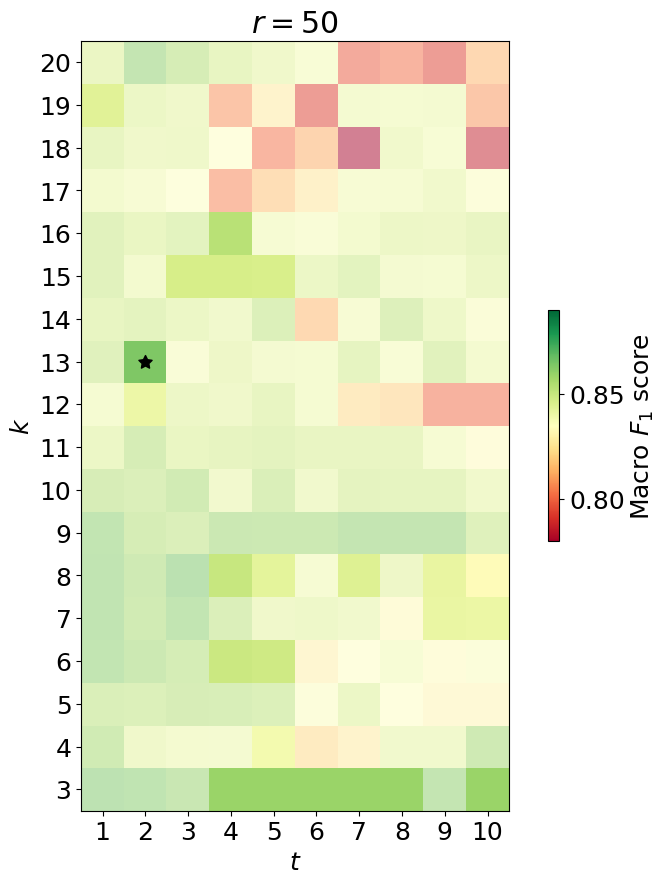

100%|██████████| 5/5 [00:34<00:00,  6.94s/it]


Number of discovered keywords: 39 

Semantic communities:

nigger --> ['nigger', 'liar', 'altright', 'weasel', 'faggot', 'scumbag', 'asshole', 'niggers', 'nigga', 'spouting', 'baiting', 'slur']
faggot --> ['faggot', 'commie', 'scumbag', 'simp', 'aww', 'crybaby', 'prob', 'beaner', 'hater', 'tranny', 'cunts', 'moron', 'pedo', 'wetback', 'braindead', 'limey', 'brainless', 'awww', 'btw', 'faggots', 'goyim', 'woah', 'commies', 'skank', 'fag', 'sluts']
retard --> []
retarded --> []
cunt --> ['cunt', 'hag', 'fag', 'gg', 'snowflake', 'tl', 'fucker']

Discovered words: ['altright', 'asshole', 'aww', 'awww', 'baiting', 'beaner', 'braindead', 'brainless', 'btw', 'commie', 'commies', 'crybaby', 'cunts', 'fag', 'faggots', 'fucker', 'gg', 'goyim', 'hag', 'hater', 'liar', 'limey', 'moron', 'nigga', 'niggers', 'pedo', 'prob', 'scumbag', 'simp', 'skank', 'slur', 'sluts', 'snowflake', 'spouting', 'tl', 'tranny', 'weasel', 'wetback', 'woah']

Train scores for LGDE expanded dictionary at $r=50$:

       

In [16]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=50$:k={best_k_50d}, t={best_t_50d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.78,vmax=0.89)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.78,vmax=0.89)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=50$')
plt.savefig('figures/lgde_f1score-50d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_50d = LGDE(seed_dict,word_list,word_vecs_50d)
lgde_50d.expand(k=best_k_50d, t=best_t_50d)

print("\nNumber of discovered keywords:", lgde_50d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_50d.seed_dict[:10]:
    print(keyword,"-->",lgde_50d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_50d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_50d.expanded_dict_, y_test, dt_test)

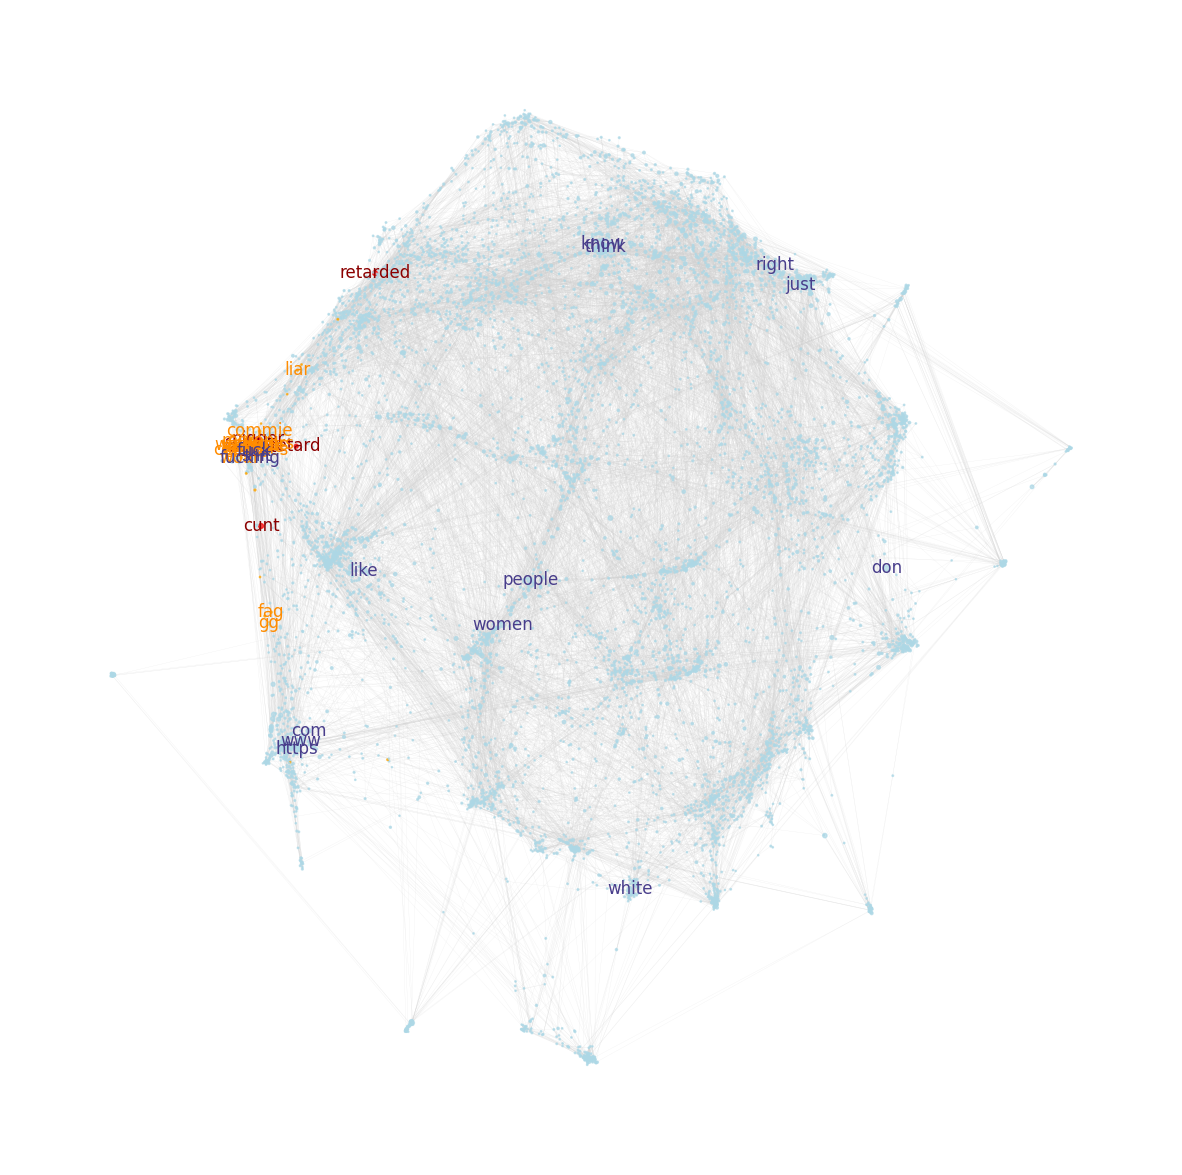

In [17]:
# visualise semantic network
lgde_50d.construct_nx_graph()
fig = lgde_50d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/redgab_semantic_network_50d.pdf",dpi=fig.dpi,bbox_inches="tight")

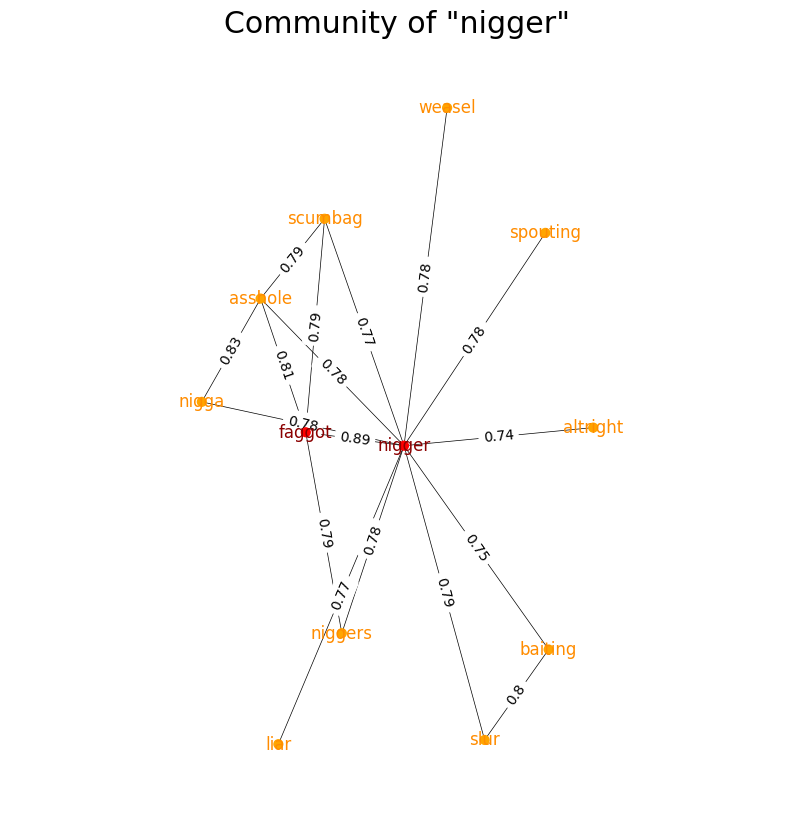

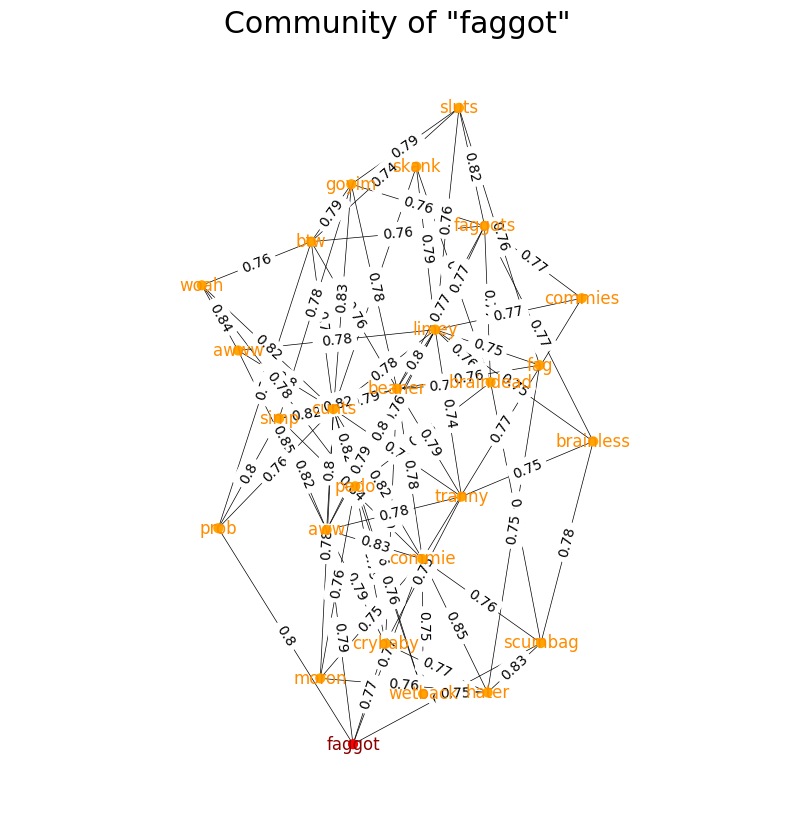

The keyword 'retard' is a singleton semantic community.
The keyword 'retarded' is a singleton semantic community.


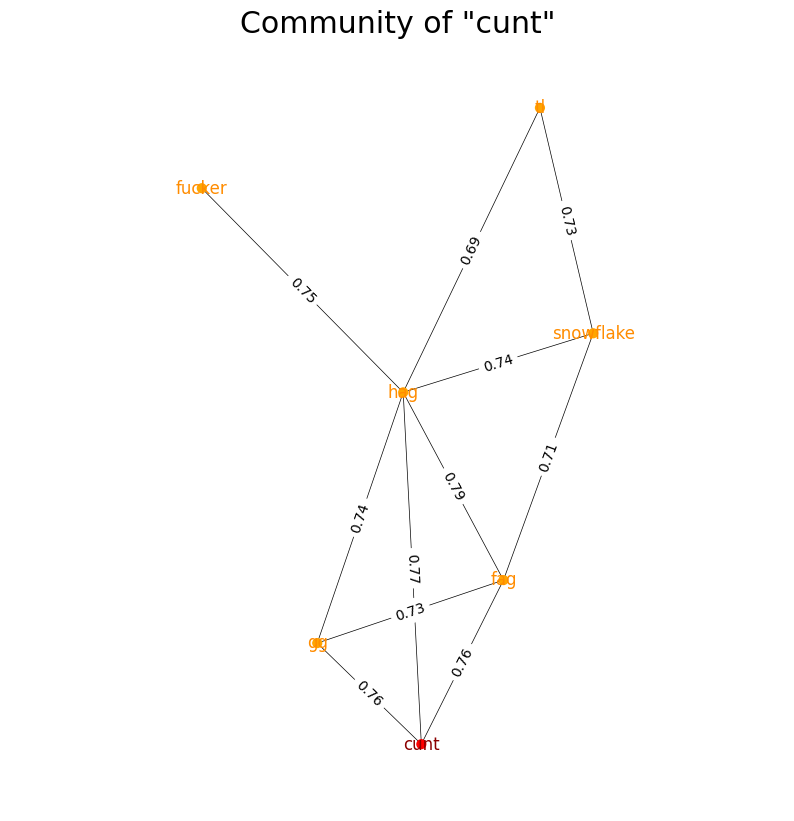

In [18]:
# plot semantic communities
lgde_50d.plot_semantic_communities(n_plots=5,figsize=(10,10),path="figures/50d-")

In [19]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_50d.discovered_dict_))]
thres_50d_prime = Thresholding(seed_dict,word_list,word_vecs_50d)
thres_50d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_50d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(thres_50d_prime.discovered_dict_))
thres_only_50_prime = list(set(thres_50d_prime.discovered_dict_) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_50_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[thres_only_50_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,4))


Test scores for same size thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.883     0.910     0.896      9057
        True      0.826     0.780     0.803      4968

    accuracy                          0.864     14025
   macro avg      0.855     0.845     0.849     14025
weighted avg      0.863     0.864     0.863     14025


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.45
Median LR+ LGDE: 2.25
Mann-Whitney U test with alternative "greater": p = 0.0289


## 5) Comparison between optimal dictionaries for dimension $r=100$

In [20]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_100d["th"]["eps"]
fscore_th = results_100d["th"]["fscore"]
precision_th = results_100d["th"]["precision"]
recall_th = results_100d["th"]["recall"]
size_th = results_100d["th"]["size"]

# unpack results for LGDE
times = results_100d["lgde"]["times"]
ks = results_100d["lgde"]["ks"]
commmunities = results_100d["lgde"]["communities"]
fscore_lgde = results_100d["lgde"]["fscore"]
precision_lgde = results_100d["lgde"]["precision"]
recall_lgde = results_100d["lgde"]["recall"]
size_lgde = results_100d["lgde"]["size"]

# apply size constraints
fscore_sc_lgde = fscore_lgde.copy()
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.NaN
fscore_sc_th[size_th > max_size] = np.NaN
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.NaN
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.NaN

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_100d = eps[ind_th]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_100d = ks[ind_lgde[0]]
best_t_100d = times[ind_lgde[1]]


### Thresholding ###

Best epsilon at $r=50$: 0.681


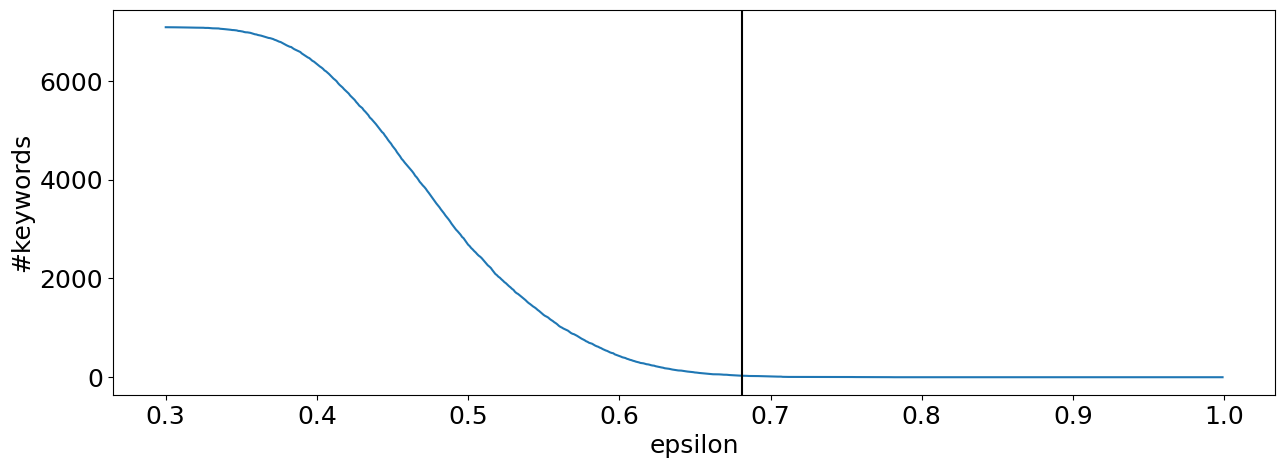

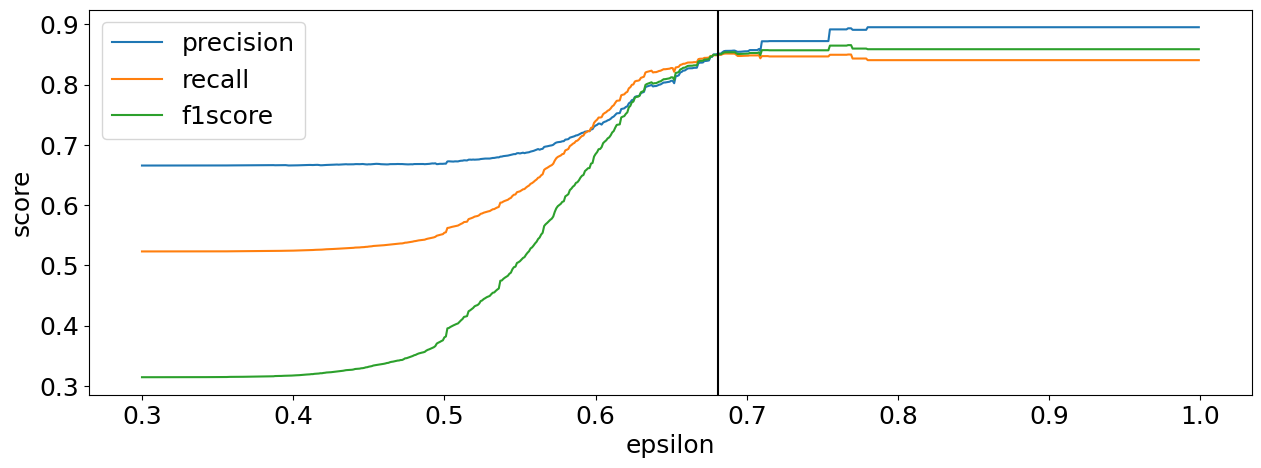

Number of discovered keywords at $r=50$: 30 

Epsilon balls:

nigger --> ['nigger', 'niggers', 'cunt', 'faggot', 'bitch', 'slur', 'weasel']
faggot --> ['nigger', 'niggers', 'cunt', 'faggot', 'crybaby', 'commie', 'bitch', 'fag']
retard --> ['retard', 'retards']
retarded --> ['honest', 'retarded', 'murderers', 'mentally', 'autistic', 'intellectually', 'incompetent', 'competent', 'offenders', 'morally', 'cared', 'engineers']
cunt --> ['nigger', 'fucking', 'fuck', 'cunt', 'faggot', 'asshole', 'bitch', 'whore', 'wetback', 'fag', 'hillbilly', 'turd', 'fuckin', 'shite', 'nigga', 'braindead']

Discovered words: ['asshole', 'autistic', 'bitch', 'braindead', 'cared', 'commie', 'competent', 'crybaby', 'engineers', 'fag', 'fuck', 'fuckin', 'fucking', 'hillbilly', 'honest', 'incompetent', 'intellectually', 'mentally', 'morally', 'murderers', 'nigga', 'niggers', 'offenders', 'retards', 'shite', 'slur', 'turd', 'weasel', 'wetback', 'whore']

Train scores for thresholding expanded dictionary at $r=50$

In [21]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_100d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_100d = Thresholding(seed_dict,word_list,word_vecs_100d)
thres_100d.expand(best_epsilon_100d)

print("Number of discovered keywords at $r=50$:", thres_100d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_100d.seed_dict[:15]:
    print(keyword,"-->",thres_100d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_100d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_100d.expanded_dict_, y_test, dt_test)


### LGDE ###

Best hyperparameters at $r=50$:k=12, t=5


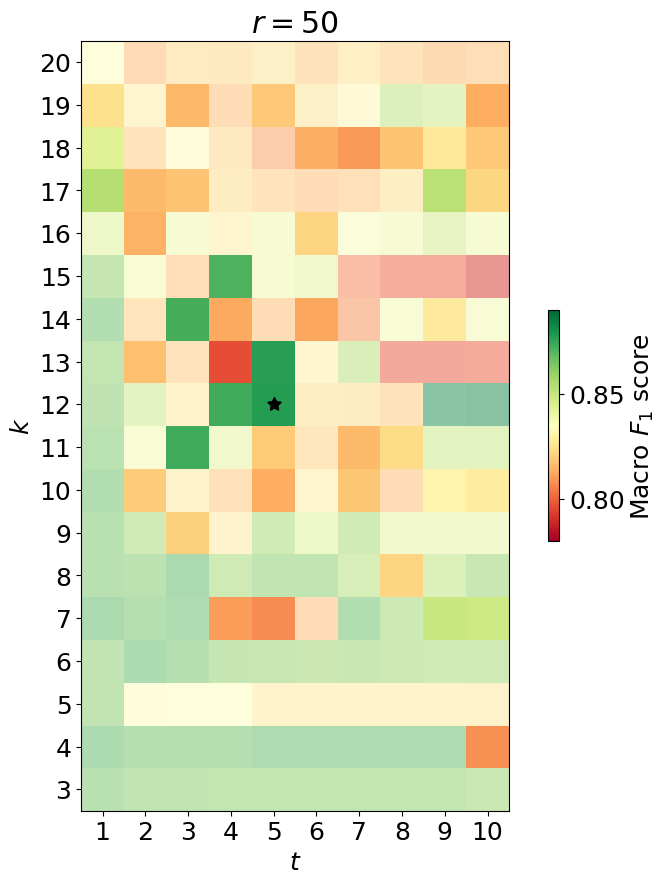

100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


Number of discovered keywords: 45 

Semantic communities:

nigger --> ['nigger', 'walkaway', 'faggot', 'cunt', 'bitch', 'fag']
faggot --> ['faggot', 'nigger', 'walkaway', 'cunt', 'bitch', 'fag']
retard --> ['retard', 'retards', 'maggot']
retarded --> []
cunt --> ['cunt', 'shite', 'nigga', 'wetback', 'pedo', 'motherfuckers', 'twat', 'cunts', 'raghead', 'braindead', 'woah', 'beaner', 'prob', 'skank', 'chinaman', 'shitty', 'turd', 'goyim', 'assholes', 'limey', 'badass', 'fuckin', 'faggots', 'wigger', 'spangle', 'stfu', 'commie', 'fucks', 'douche', 'thot', 'awww', 'fuckers', 'motherfucker', 'boobs', 'ummm', 'pilled', 'simp', 'btw', 'homos', 'commies', 'betas']

Discovered words: ['assholes', 'awww', 'badass', 'beaner', 'betas', 'bitch', 'boobs', 'braindead', 'btw', 'chinaman', 'commie', 'commies', 'cunts', 'douche', 'fag', 'faggots', 'fuckers', 'fuckin', 'fucks', 'goyim', 'homos', 'limey', 'maggot', 'motherfucker', 'motherfuckers', 'nigga', 'pedo', 'pilled', 'prob', 'raghead', 'retards', 

In [22]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=50$:k={best_k_100d}, t={best_t_100d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.78,vmax=0.89)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.78,vmax=0.89)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=50$')
plt.savefig('figures/lgde_f1score-100d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_100d = LGDE(seed_dict,word_list,word_vecs_100d)
lgde_100d.expand(k=best_k_100d, t=best_t_100d)

print("\nNumber of discovered keywords:", lgde_100d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_100d.seed_dict[:10]:
    print(keyword,"-->",lgde_100d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_100d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_100d.expanded_dict_, y_test, dt_test)

In [23]:
print("Size of semantic community of 'c**t'", len(lgde_100d.semantic_communities_["cunt"]))

Size of semantic community of 'c**t' 41


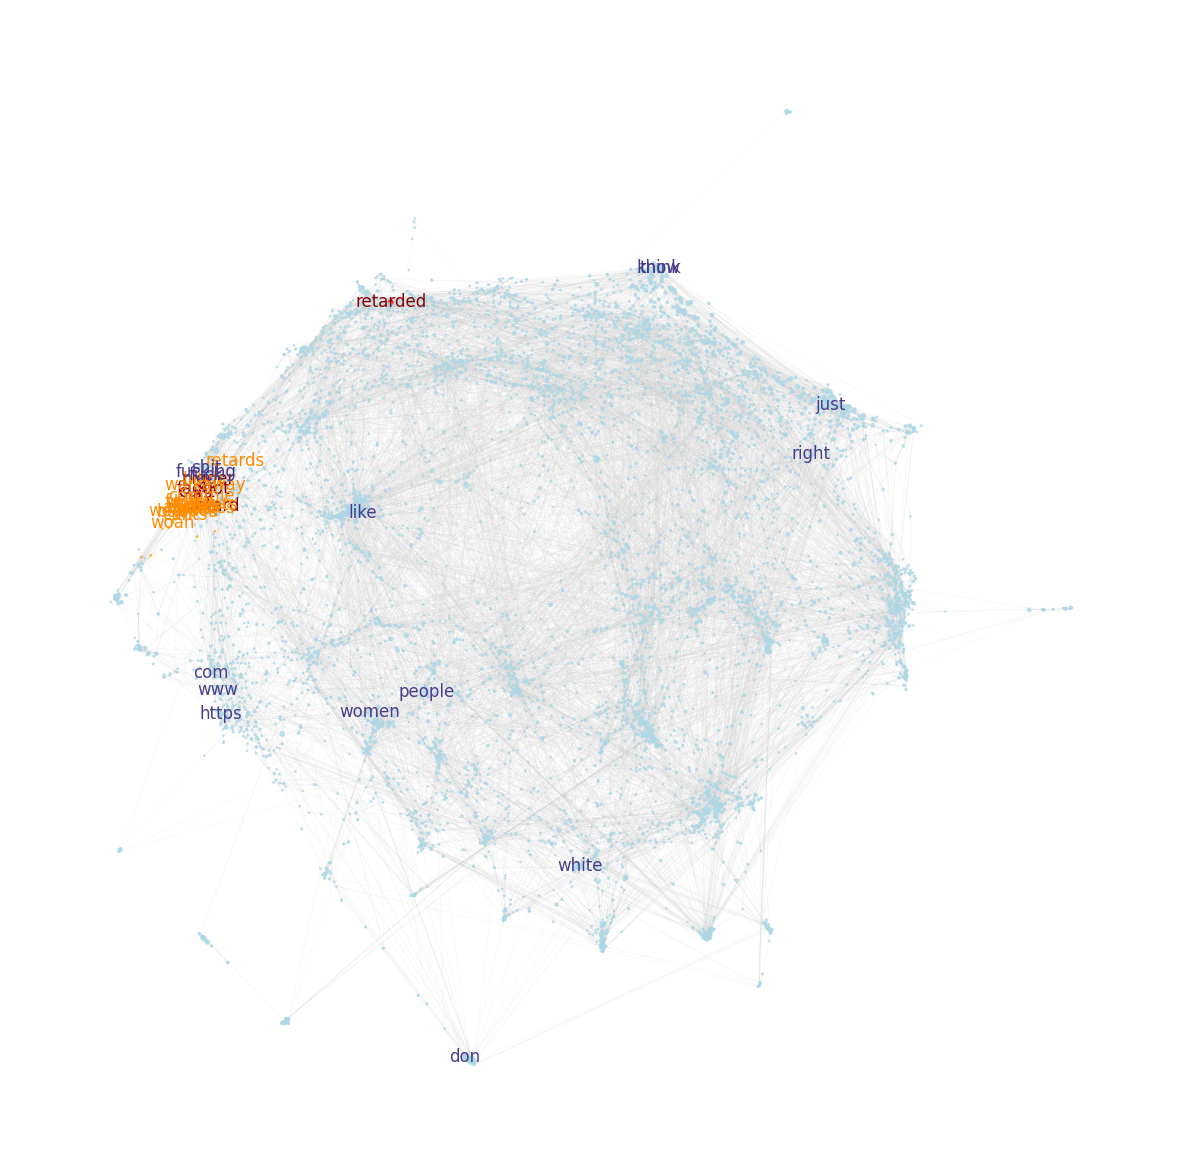

In [24]:
# visualise semantic network
lgde_100d.construct_nx_graph()
fig = lgde_100d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/redgab_semantic_network_100d.pdf",dpi=fig.dpi,bbox_inches="tight")

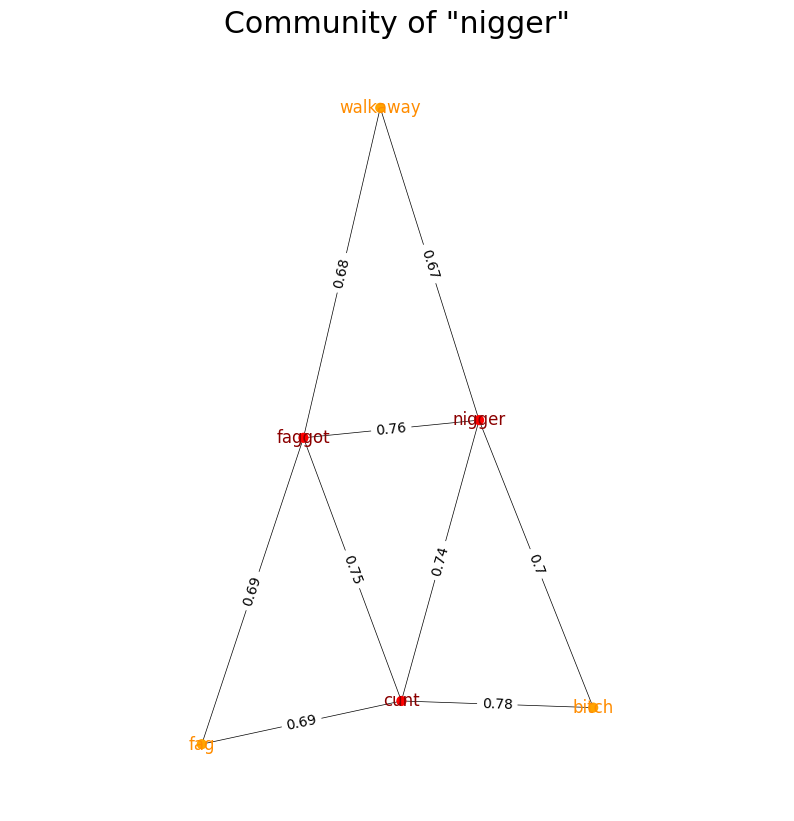

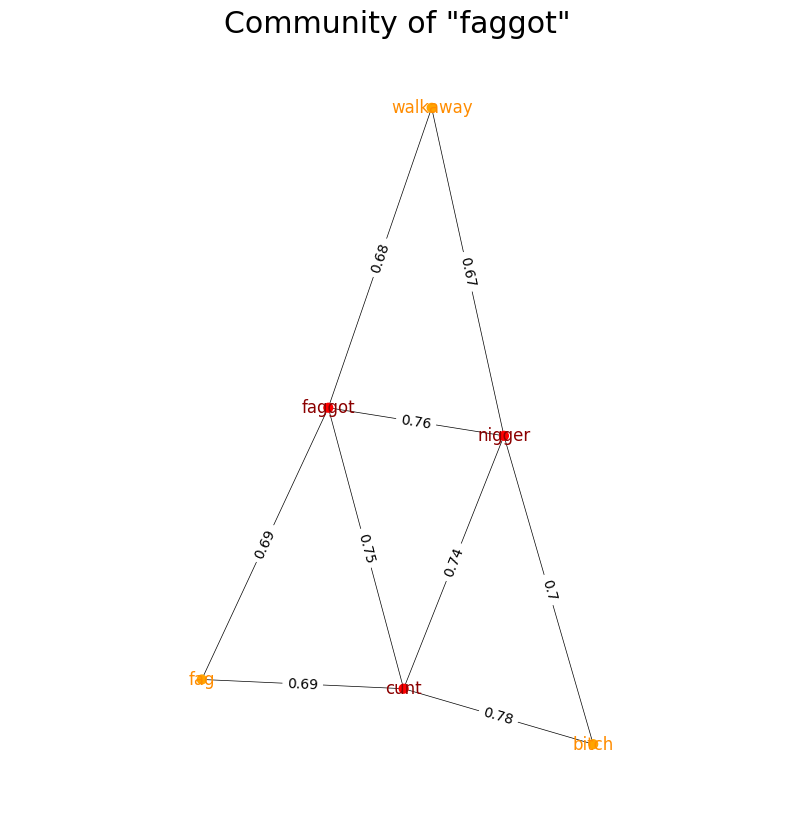

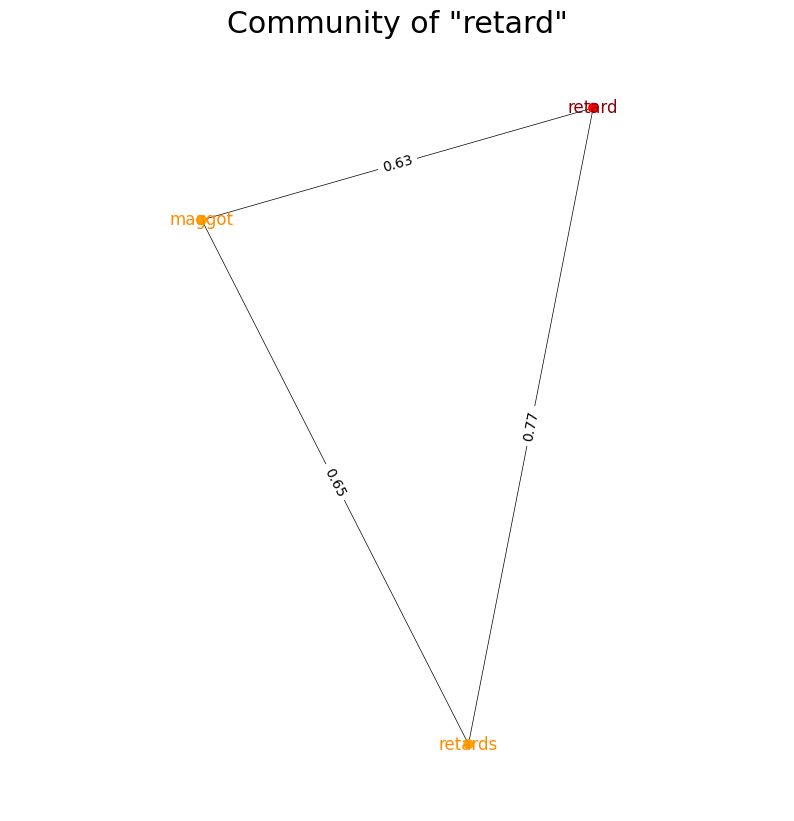

The keyword 'retarded' is a singleton semantic community.


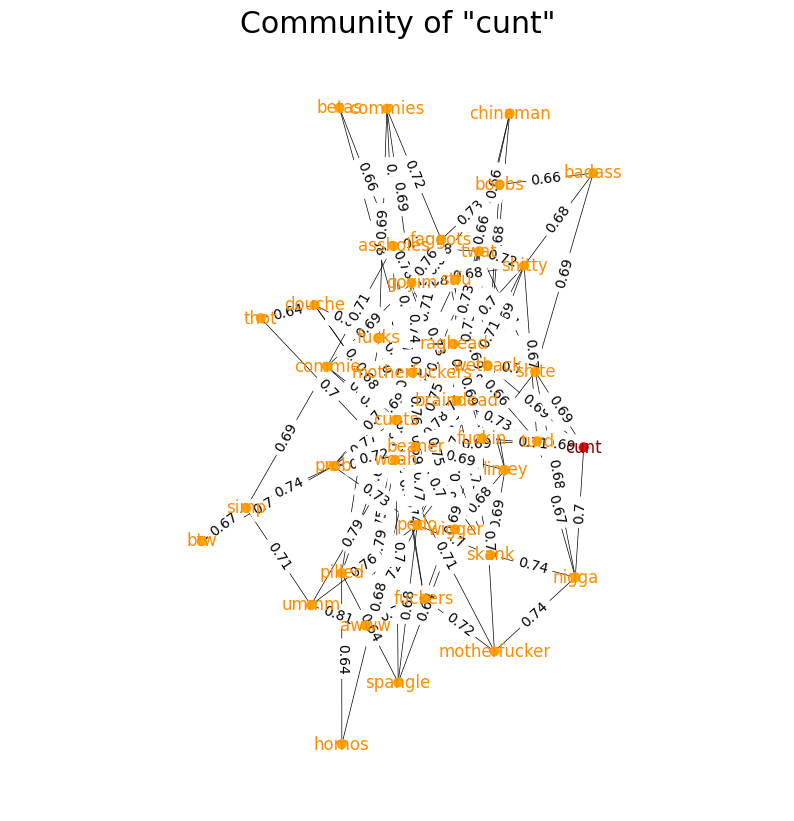

In [25]:
# plot semantic communities
lgde_100d.plot_semantic_communities(n_plots=5,figsize=(10,10),path="figures/100d-")

In [26]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_100d.discovered_dict_))]
thres_100d_prime = Thresholding(seed_dict,word_list,word_vecs_100d)
thres_100d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_100d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_50 =  list(set(lgde_100d.discovered_dict_) -  set(thres_100d_prime.discovered_dict_))
thres_only_50_prime = list(set(thres_100d_prime.discovered_dict_) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_50_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[thres_only_50_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,4))


Test scores for same size thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.893     0.880     0.887      9057
        True      0.787     0.808     0.798      4968

    accuracy                          0.855     14025
   macro avg      0.840     0.844     0.842     14025
weighted avg      0.856     0.855     0.855     14025


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.53
Median LR+ LGDE: 2.59
Mann-Whitney U test with alternative "greater": p = 0.0191


## 6) Comparison between optimal dictionaries for dimension $r=300$

In [27]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_300d["th"]["eps"]
fscore_th = results_300d["th"]["fscore"]
precision_th = results_300d["th"]["precision"]
recall_th = results_300d["th"]["recall"]
size_th = results_300d["th"]["size"]

# unpack results for LGDE
times = results_300d["lgde"]["times"]
ks = results_300d["lgde"]["ks"]
commmunities = results_300d["lgde"]["communities"]
fscore_lgde = results_300d["lgde"]["fscore"]
precision_lgde = results_300d["lgde"]["precision"]
recall_lgde = results_300d["lgde"]["recall"]
size_lgde = results_300d["lgde"]["size"]

# apply size constraints
fscore_sc_lgde = fscore_lgde.copy()
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.NaN
fscore_sc_th[size_th > max_size] = np.NaN
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.NaN
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.NaN

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_300d = eps[ind_th]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_300d = ks[ind_lgde[0]]
best_t_300d = times[ind_lgde[1]]


### Thresholding ###

Best epsilon at $r=50$: 0.552


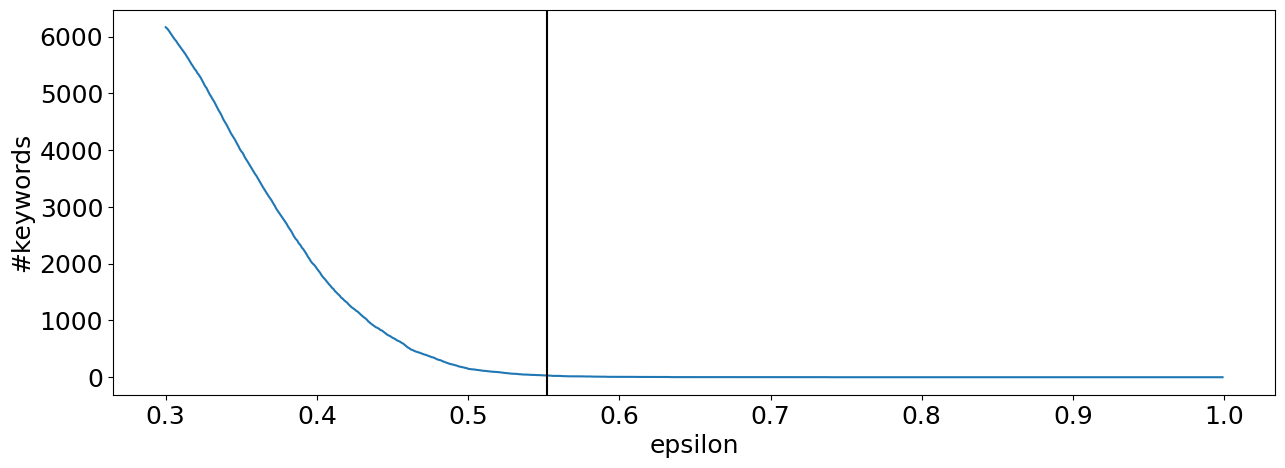

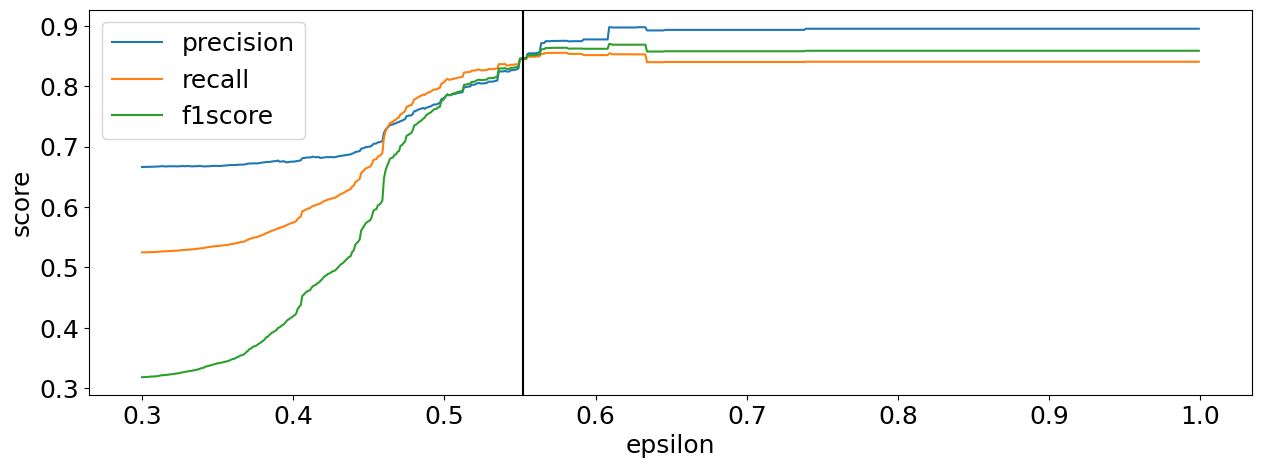

Number of discovered keywords at $r=50$: 31 

Epsilon balls:

nigger --> ['nigger', 'fucking', 'niggers', 'faggot', 'word', 'bitch', 'derogatory', 'fag', 'slur', 'nigga']
faggot --> ['nigger', 'fucking', 'faggot', 'ugh', 'simp', 'aww', 'awww', 'ahhh']
retard --> ['retard', 'retards']
retarded --> ['retarded', 'mental', 'murderers', 'cruel', 'mentally', 'convicted', 'autistic', 'incompetent', 'mildly', 'competent', 'retardation', 'offenders', 'cared', 'disabled', 'execution', 'execute', 'executed']
cunt --> ['fucking', 'fuck', 'cunt', 'bitch']

Discovered words: ['ahhh', 'autistic', 'aww', 'awww', 'bitch', 'cared', 'competent', 'convicted', 'cruel', 'derogatory', 'disabled', 'execute', 'executed', 'execution', 'fag', 'fuck', 'fucking', 'incompetent', 'mental', 'mentally', 'mildly', 'murderers', 'nigga', 'niggers', 'offenders', 'retardation', 'retards', 'simp', 'slur', 'ugh', 'word']

Train scores for thresholding expanded dictionary at $r=50$:

              precision    recall  f1-scor

In [28]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_300d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_300d = Thresholding(seed_dict,word_list,word_vecs_300d)
thres_300d.expand(best_epsilon_300d)

print("Number of discovered keywords at $r=50$:", thres_300d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_300d.seed_dict[:15]:
    print(keyword,"-->",thres_300d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_300d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_300d.expanded_dict_, y_test, dt_test)


### LGDE ###

Best hyperparameters at $r=50$:k=19, t=2


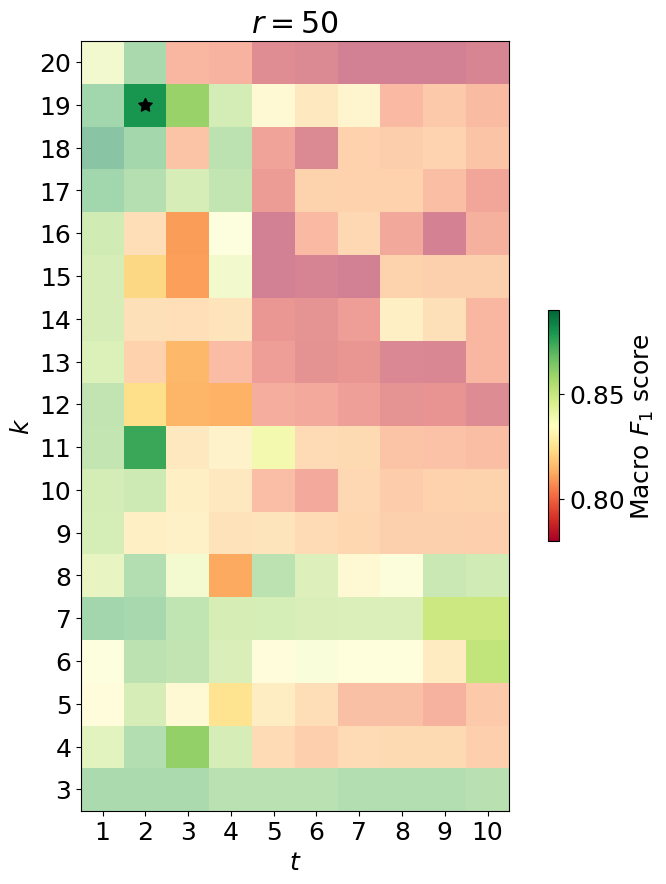

100%|██████████| 5/5 [01:33<00:00, 18.64s/it]


Number of discovered keywords: 38 

Semantic communities:

nigger --> []
faggot --> ['faggot', 'twat', 'cunt', 'wetback', 'raghead', 'shite', 'woah', 'pedo', 'beaner', 'cunts', 'fucker', 'awww', 'skank', 'douche', 'braindead', 'scumbag', 'wigger', 'goyim', 'simp', 'homos', 'aww', 'faggots', 'stfu', 'foxnews', 'ummm', 'thot', 'nigga', 'motherfucker', 'motherfuckers', 'fuckers', 'commies']
retard --> ['retard', 'retards', 'goalposts', 'misandry', 'brainwashing', 'potus', 'btw', 'tranny', 'retardation', 'shite', 'sucks', 'faggots']
retarded --> []
cunt --> ['cunt', 'twat', 'wetback', 'faggot', 'raghead', 'shite', 'woah', 'pedo', 'beaner', 'cunts', 'fucker', 'awww', 'skank', 'douche', 'braindead', 'scumbag', 'wigger', 'goyim', 'simp', 'homos', 'aww', 'faggots', 'stfu', 'foxnews', 'ummm', 'thot', 'nigga', 'motherfucker', 'motherfuckers', 'fuckers', 'commies']

Discovered words: ['aww', 'awww', 'beaner', 'braindead', 'brainwashing', 'btw', 'commies', 'cunts', 'douche', 'faggots', 'foxnews',

In [29]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=50$:k={best_k_300d}, t={best_t_300d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.78,vmax=0.89)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.78,vmax=0.89)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=50$')
plt.savefig('figures/lgde_f1score-300d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_300d = LGDE(seed_dict,word_list,word_vecs_300d)
lgde_300d.expand(k=best_k_300d, t=best_t_300d)

print("\nNumber of discovered keywords:", lgde_300d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_300d.seed_dict[:10]:
    print(keyword,"-->",lgde_300d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_300d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(lgde_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_300d.expanded_dict_, y_test, dt_test)

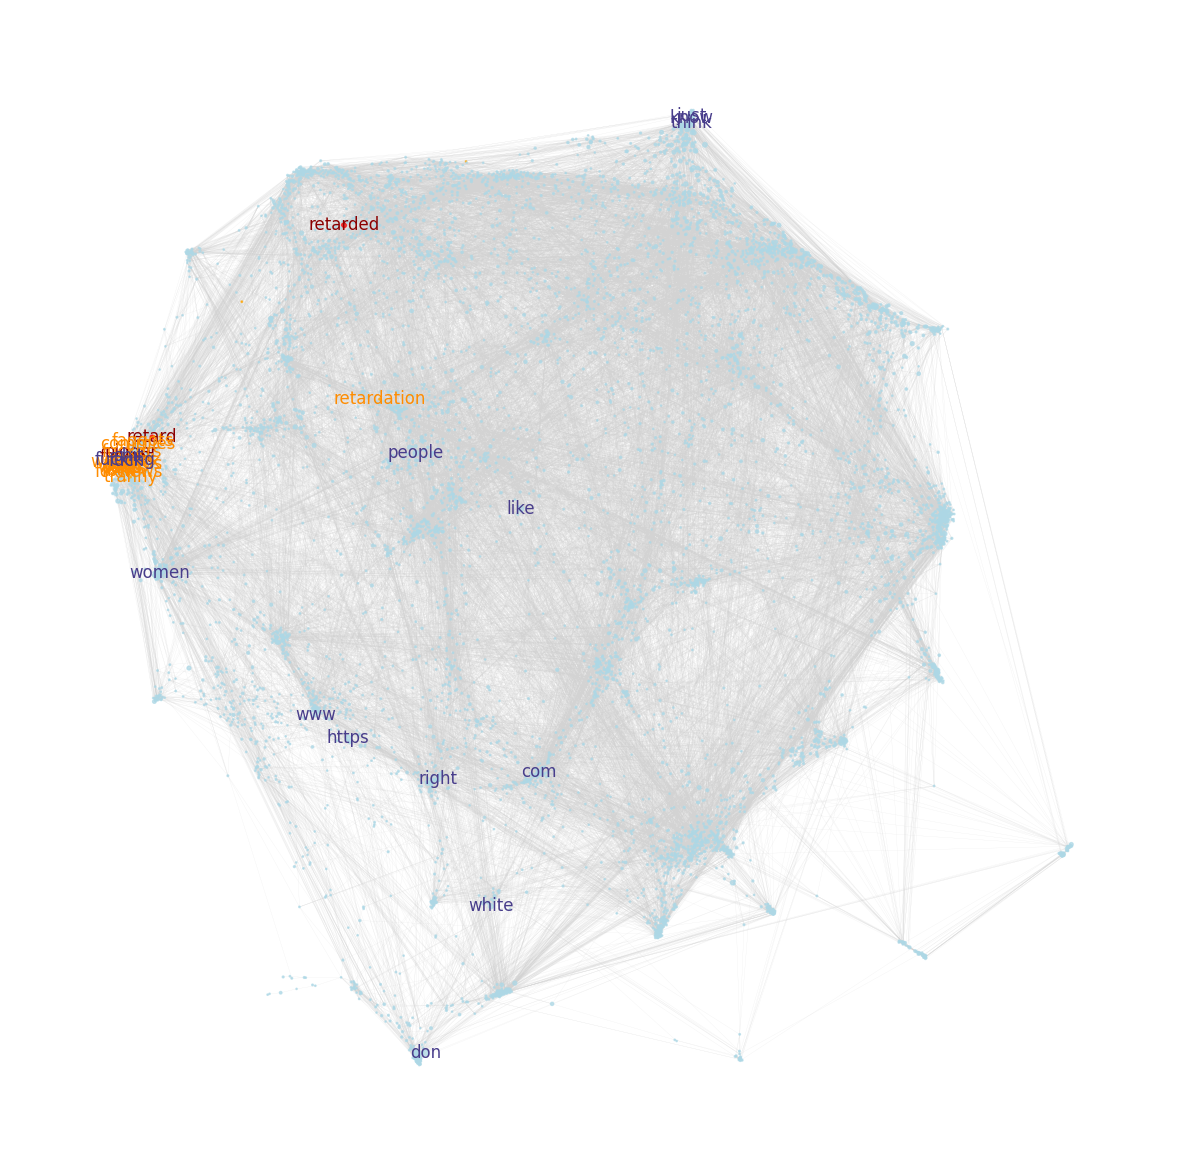

In [30]:
# visualise semantic network
lgde_300d.construct_nx_graph()
fig = lgde_300d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/redgab_semantic_network_300d.pdf",dpi=fig.dpi,bbox_inches="tight")

In [31]:
print("Size of semantic community of 'c**t'", len(lgde_300d.semantic_communities_["cunt"]))

Size of semantic community of 'c**t' 31


The keyword 'nigger' is a singleton semantic community.


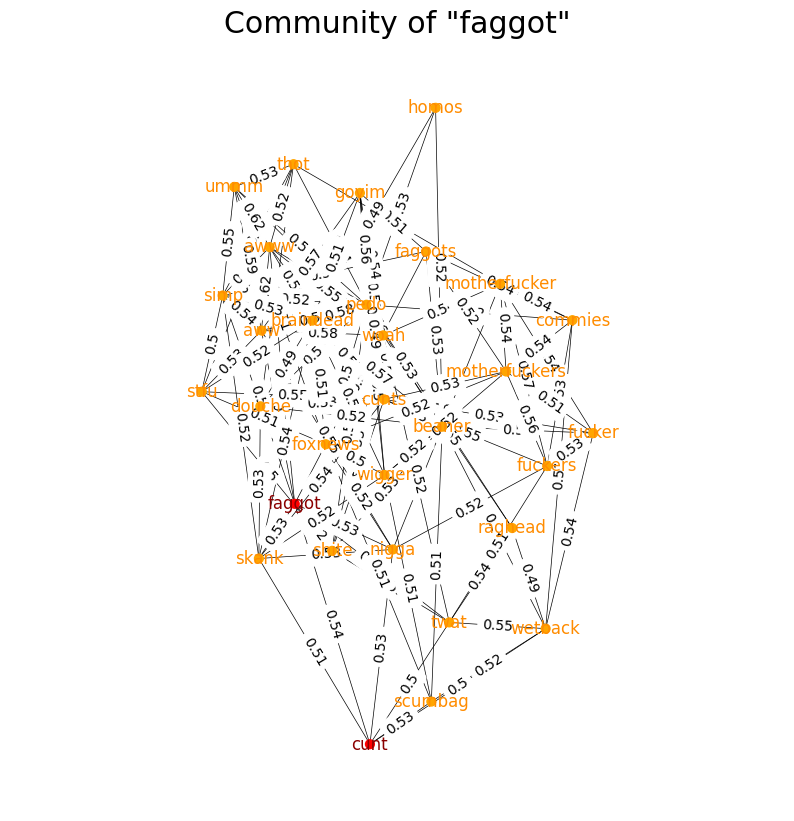

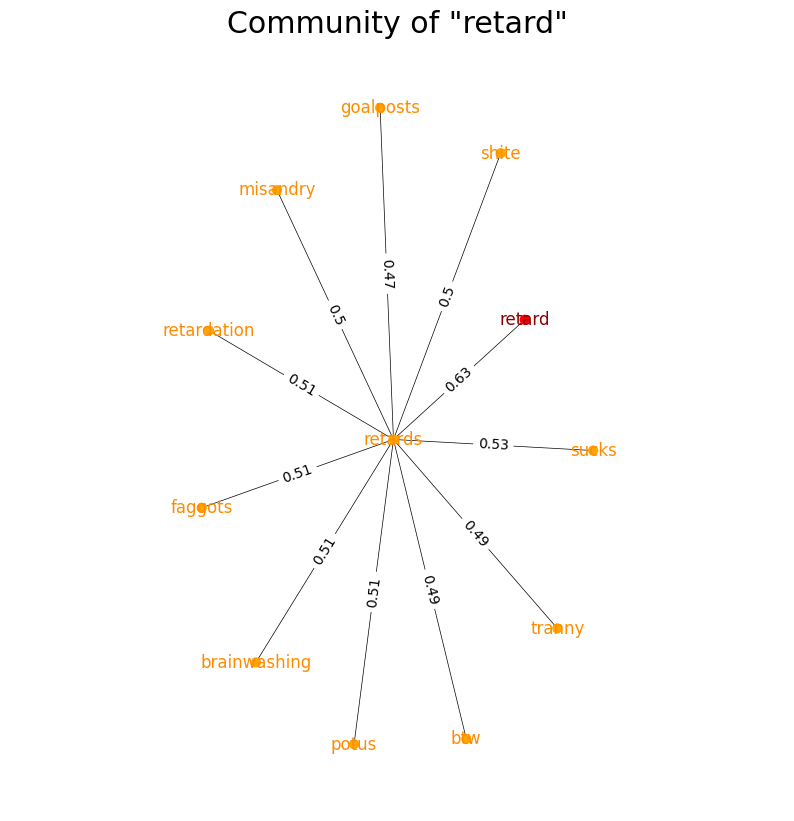

The keyword 'retarded' is a singleton semantic community.


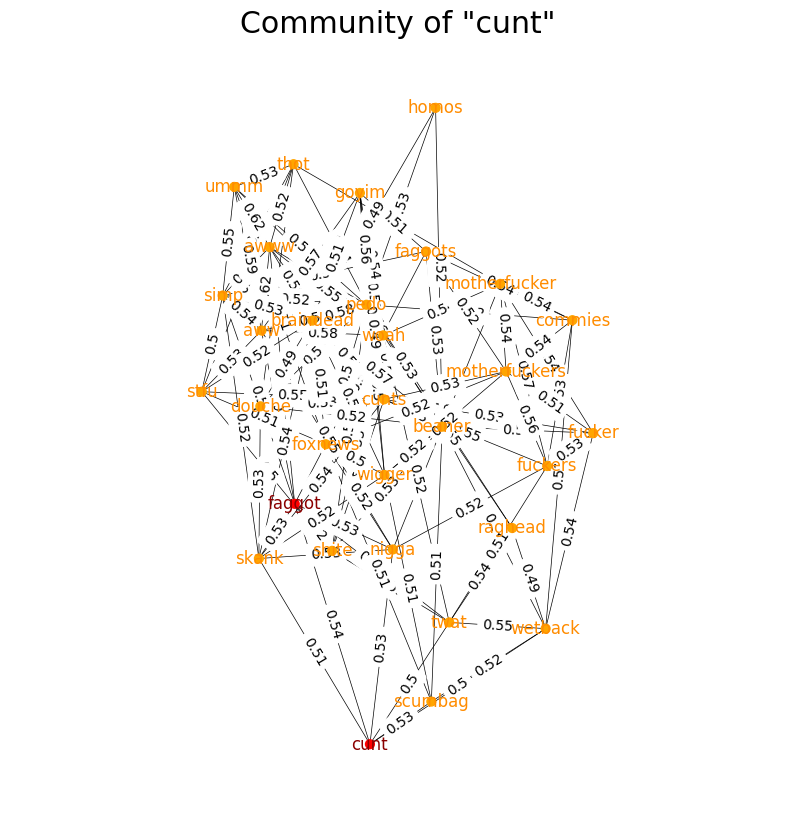

In [32]:
# plot semantic communities
lgde_300d.plot_semantic_communities(n_plots=5,figsize=(10,10),path="figures/300d-")

In [33]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_300d.discovered_dict_))]
thres_300d_prime = Thresholding(seed_dict,word_list,word_vecs_300d)
thres_300d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_300d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_50 =  list(set(lgde_300d.discovered_dict_) -  set(thres_300d_prime.discovered_dict_))
thres_only_50_prime = list(set(thres_300d_prime.discovered_dict_) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_50_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[thres_only_50_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,4))


Test scores for same size thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.892     0.859     0.875      9057
        True      0.760     0.811     0.784      4968

    accuracy                          0.842     14025
   macro avg      0.826     0.835     0.830     14025
weighted avg      0.845     0.842     0.843     14025


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.25
Median LR+ LGDE: 2.66
Mann-Whitney U test with alternative "greater": p = 0.0236
